### Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

### Parámetros

In [2]:
# Parámetros de LoRa
SF = 7                     # Spreading Factor
BW = 125e3                 # Bandwidth en Hz (125 kHz)
Fs = 1e6                   # Frecuencia de muestreo (1 MHz)
T_symbol = 2**SF / BW     # Duración de un símbolo
N = 2**SF                  # Número de muestras por símbolo (128)
Ts = T_symbol / N         # Período de muestreo efectivo

# Tiempo y muestras
Ts = 1 / BW               # Duración de cada chip
T_symbol = N * Ts         # Duración de un símbolo

t = np.linspace(0, T_symbol, N, endpoint=False)  # Vector de tiempo


### Generador de hipotesis 

In [3]:
#k indica la cantidad de vectores a generar
def generate_lora_bits(k):
    bits_totales = k            # Número de símbolos a generar
    info_bits = np.zeros((bits_totales, SF),dtype=int)  # Matriz para almacenar los bits de información

    for i in range(bits_totales):
        for j in range(SF):
            info_bits[i, j] = np.random.randint(0, 2)
    
    return info_bits

### Encoder

In [4]:
def encode_lora_symbol(k):
    bits = generate_lora_bits(k)  # Generar k símbolos de LoRa
    simbolos = np.zeros((k, 1),dtype=int)  # Matriz para almacenar los símbolos
    for i in range(k):
        print("Bits:", bits[i])
        for j in range(SF):
            simbolos[i] += bits[i, SF - j - 1] * (2 ** j)  # recorremos de derecha a izquierda
            
        print("Valor decimal:", simbolos[i,0])
    return simbolos, bits

### Decoder


In [5]:
def decoder(simbolos):
    bits = np.zeros((len(simbolos), SF), dtype=int)

    for i, simbolo in enumerate(simbolos):
        valor = simbolo[0] if isinstance(simbolo, np.ndarray) else simbolo
        bin_str = format(valor, f'0{SF}b')  # convierte a binario, con ceros a la izquierda
        bits[i] = [int(b) for b in bin_str]   # guarda como vector de bits
        print("Simbolo:", simbolo, "Bits decodificados:", bits[i])
        

    return bits

### Cálculo del ber

In [6]:
def calcular_ber(bits_enviados, bits_recibidos):
    errores = np.sum(bits_enviados != bits_recibidos)  # Cuenta los bits diferentes
    total_bits = bits_enviados.size  # Total de bits transmitidos
    ber = errores / total_bits
    return errores, total_bits, ber


### Calculo del SER

In [7]:
def calcular_ser(simbolos_enviados, simbolos_recibidos):
    errores = np.sum(simbolos_enviados.flatten() != simbolos_recibidos.flatten())
    total_simbolos = simbolos_enviados.shape[0]
    ser = errores / total_simbolos
    return errores, total_simbolos, ser

### Waveform former

In [8]:
def waveform_lora(symbol):
    
    k = np.arange(N)
    fase = 2 * np.pi * ((symbol + k) % N) * k * Ts * BW / N
    wave = np.exp(1j * fase) / np.sqrt(N)
    return wave

### n-tupler 

In [9]:
def n_tupler(wave):
    # Paso 1: Dechirping
    k = np.arange(N)
    down_chirp = np.exp(-1j * 2 * np.pi * k**2 / N)
    d = wave * down_chirp

    # Paso 2: DFT (usando FFT) con fftshift
    spectrum = np.abs(np.fft.fft(d, n=N)) / np.sqrt(N)  # Normalización
    spectrum_shifted = np.fft.fftshift(spectrum)  # Reordenar frecuencias

    # Detectar símbolo
    detected_symbol = np.argmax(spectrum_shifted)
    simbolo = (detected_symbol - N//2) % N  # Mapear al símbolo LoRa
    
    print(f"Símbolo detectado: {simbolo}")
    return simbolo
    

### Ruido blanco

In [10]:
def add_noise(signal, snr_db):
    """Añade ruido blanco gaussiano al signal basado en SNR (dB)."""
    snr = 10 ** (snr_db / 10)  # Convertir SNR de dB a lineal
    power_signal = np.mean(np.abs(signal) ** 2)
    power_noise = power_signal / snr
    noise = np.random.normal(0, np.sqrt(power_noise), signal.shape)
    return signal + noise

### Ploteo

In [11]:
# === Ploteo ===

def ploteo(signal, symbol):

    plt.figure(figsize=(10, 5))

    # Señal en el tiempo
    plt.subplot(2, 1, 1)
    plt.plot(t * 1e3, np.real(signal), label='Parte Real')
    plt.title(f"Forma de onda LoRa (SF={SF}, símbolo={symbol})")
    plt.xlabel("Tiempo [ms]")
    plt.ylabel("Amplitud")



    # Calcular frecuencia instantánea
    # Derivada de la fase en el tiempo
    inst_phase = np.unwrap(np.angle(signal))
    inst_freq = np.diff(inst_phase) * Fs / (2 * np.pi)  # Hz
    t_mid = (t[:-1] + t[1:]) / 2  # Para alinear el tiempo con derivada

    # Ploteo
    plt.subplot(2, 1, 2)
    plt.plot(t_mid * 1e3, inst_freq / 1e3)
    plt.title(f"Frecuencia Instantánea del Chirp LoRa (símbolo={symbol}, SF={SF})")
    plt.xlabel("Tiempo [ms]")
    plt.ylabel("Frecuencia [kHz]")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()

### Graficos BER vs SNR

In [ ]:
# Gráfico
def plot_ber(snr_values, ber_values):
    plt.figure(figsize=(10, 6))
    plt.semilogy(snr_values, ber_values, 'b-o', label='BER')
    #plt.semilogy(snr_values, ser_values, 'r-s', label='SER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('BER vs. SNR (Escala Logarítmica)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

### Gráfico SER vs SNR

In [ ]:
def plot_ber(snr_values, ser_values):
    plt.figure(figsize=(10, 6))
    #plt.semilogy(snr_values, ber_values, 'b-o', label='BER')
    plt.semilogy(snr_values, ser_values, 'r-s', label='SER')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Error Rate')
    plt.title('SER vs. SNR (Escala Logarítmica)')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

## Simulación

Bits: [1 0 0 1 0 1 1]
Valor decimal: 75
Bits: [0 0 0 1 0 0 0]
Valor decimal: 8
Bits: [0 1 1 0 0 1 1]
Valor decimal: 51
Bits: [1 0 0 1 0 1 0]
Valor decimal: 74
Bits: [0 0 0 1 0 1 0]
Valor decimal: 10
Bits: [1 0 0 1 0 0 0]
Valor decimal: 72
Bits: [1 1 1 1 1 0 1]
Valor decimal: 125
Bits: [0 0 1 0 0 1 0]
Valor decimal: 18
Bits: [0 0 0 0 0 1 0]
Valor decimal: 2
Bits: [1 0 1 0 0 0 1]
Valor decimal: 81
Bits: [1 1 0 1 0 1 0]
Valor decimal: 106
Bits: [0 0 1 0 0 0 0]
Valor decimal: 16
Bits: [0 1 1 1 1 1 0]
Valor decimal: 62
Bits: [0 0 1 0 0 0 0]
Valor decimal: 16
Bits: [1 1 1 1 1 0 0]
Valor decimal: 124
Bits: [0 1 1 1 0 1 0]
Valor decimal: 58
Bits: [1 0 1 0 0 0 0]
Valor decimal: 80
Bits: [0 1 0 0 0 0 0]
Valor decimal: 32
Bits: [0 1 0 0 1 1 0]
Valor decimal: 38
Bits: [0 0 1 1 1 1 1]
Valor decimal: 31
Bits: [0 1 0 1 1 1 1]
Valor decimal: 47
Bits: [0 1 0 1 0 0 1]
Valor decimal: 41
Bits: [0 0 0 0 0 1 0]
Valor decimal: 2
Bits: [0 1 0 1 0 0 1]
Valor decimal: 41
Bits: [1 1 0 1 1 0 1]
Valor decimal: 109

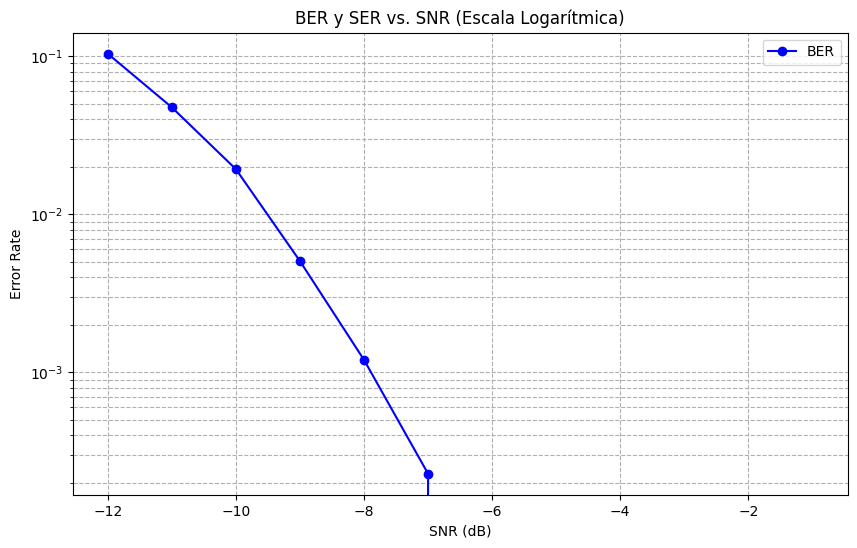

In [ ]:
errores_ber = []
errores_ser = []
for i in range(12):    
    info_enviada, bits_enviados = encode_lora_symbol(5000)
    ondas_enviadas = [add_noise(waveform_lora(symbol), -(12 - i)) for symbol in info_enviada]
    simbolos_detectados = np.array([n_tupler(wave) for wave in ondas_enviadas]).reshape(-1, 1)
    bits_recibidos = decoder(simbolos_detectados)
    errores_ber.append(calcular_ber(bits_enviados, bits_recibidos)[2])
    errores_ser.append(calcular_ser(info_enviada, simbolos_detectados)[2])
    
plot_ber(range(-12, 0), errores_ber)





